In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st

In [2]:
df = pd.read_csv('../../masked/patients_info.csv', index_col=0)
df

,pCR,HER2_Status,ER_Status,T,N,Ki-67,Age,Chemo,Histologic_Grade,antiHER2,WES,Methylation,RNA,Protein
Patient_ID,,,,,,,,,,,,,,
PS001,0,Pos,Neg,T3,N3,0.30,38,TCb,II,1,1,1,1,1
PS002,0,Neg,Neg,T1b,N1,0.70,67,TCb,III,0,1,1,1,1
PS003,0,Pos,Pos,T2,N1,0.20,35,EC-T,NaN,1,0,1,1,1
PS004,1,Neg,Neg,T2,N1,0.75,52,TCb,III,0,1,1,1,1
PS005,1,Pos,Neg,T2,N1,0.30,45,EC-T,III,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PS145,1,Neg,Neg,T2,N0,0.90,54,EC-T,III,0,1,1,1,1
PS146,0,Neg,Neg,T2,N1,0.90,55,EC-T,III,0,1,1,1,1
PS147,1,Pos,Pos,T2,N0,0.70,73,Others,II,1,1,1,1,1


In [3]:
res_sub = pd.crosstab(df['HER2_Status']+df['ER_Status'], df['pCR'])
print(st.chi2_contingency(res_sub))
res_sub['ratio'] = res_sub[1]/(res_sub[1]+res_sub[0])
res_sub

(10.042942032013222, 0.006594818487035124, 2, array([[21.63758389, 30.36241611],
       [17.47651007, 24.52348993],
       [22.88590604, 32.11409396]]))


pCR,0,1,ratio
row_0,,,
NegNeg,27,25,0.480769
PosNeg,9,33,0.785714
PosPos,26,29,0.527273


In [4]:
res_chemo = pd.crosstab([df['HER2_Status']+df['ER_Status'],df[df['Chemo']!='Others']['Chemo'],],\
            df['pCR'])[[1,0]].sort_index(ascending=[0,1])

res_chemo['ratio'] = res_chemo[1]/(res_chemo[1]+res_chemo[0])
res_chemo

pCR            1   0     ratio
row_0  Chemo                  
PosPos EC-T   12   9  0.571429
       TCb    14  12  0.538462
       TY      2   3  0.400000
PosNeg EC-T   11   3  0.785714
       TCb    19   5  0.791667
       TY      2   0  1.000000
NegNeg EC-T   11  15  0.423077
       TCb    13  11  0.541667

In [5]:
res_T = pd.crosstab(df['T'].apply(lambda x:x[:2]), df['pCR'])
res_T['ratio'] = res_T[1]/(res_T[1]+res_T[0])
res_T

pCR,0,1,ratio
T,,,
T1,3,8,0.727273
T2,42,73,0.634783
T3,11,4,0.266667
T4,6,2,0.250000


In [6]:
res_T2 = pd.crosstab(df['T'].apply(lambda x:x[:2])>'T2', df['pCR'])
print(st.fisher_exact(res_T2))
res_T2['ratio'] = res_T2[1]/(res_T2[1]+res_T2[0])
res_T2

(0.19607843137254902, 0.0009828665956327963)


pCR,0,1,ratio
T,,,
False,45,81,0.642857
True,17,6,0.260870


In [7]:
res_N = pd.crosstab(df['N'].apply(lambda x:x[:2])!='N0', df['pCR'])
print(st.fisher_exact(res_N))
res_N['ratio'] = res_N[1]/(res_N[1]+res_N[0])
res_N

(0.31001890359168244, 0.001285181197839668)


pCR,0,1,ratio
N,,,
False,16,46,0.741935
True,46,41,0.471264


In [8]:
res_N = pd.crosstab(df['N'].apply(lambda x:x[:2]), df['pCR'])
res_N['ratio'] = res_N[1]/(res_N[1]+res_N[0])
res_N

pCR,0,1,ratio
N,,,
N0,16,46,0.741935
N1,39,34,0.465753
N2,5,4,0.444444
N3,2,3,0.600000


(<Figure size 1152x1152 with 1 Axes>, <AxesSubplot:>)

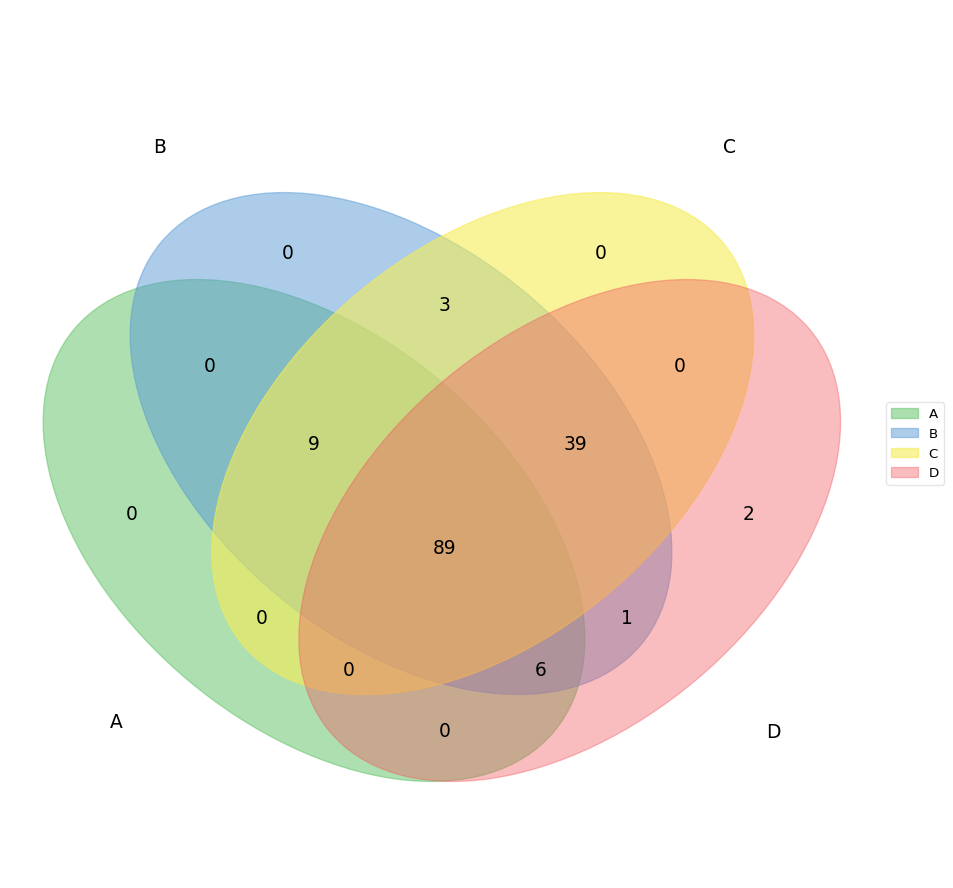

In [9]:
from pyvenn import venn
labels = venn.get_labels([
            set(df[df['WES']==1].index),
            set(df[df['Methylation']==1].index),
            set(df[df['RNA']==1].index),
            set(df[df['Protein']==1].index),
        ])

venn.venn4(labels,)

In [10]:
df_multireg = df.dropna()

df_multireg['HER2'] = (df_multireg['HER2_Status']=='Pos')*1
df_multireg['ER'] = (df_multireg['ER_Status']=='Pos')*1
df_multireg['T'] = 1-(df_multireg['T'].str.contains('T1|T2'))
df_multireg['N'] = 1-(df_multireg['N'].str.contains('N0'))

df_multireg['KI67'] = df_multireg['Ki-67']

df_multireg['Chemo'] = 1*(df_multireg['Chemo']=='TCb')

df_multireg['Histologic_Grade'] = 1*(df_multireg['Histologic_Grade']=='III')

df_multireg[['pCR','HER2','ER','T','N','KI67','Age','Chemo','Histologic_Grade','antiHER2']].to_csv('./linear_nona.csv')

In [11]:
import numpy as np
pval = pd.read_csv('./multi.pval.csv', index_col=0)
OR = pd.read_csv('./multi.OR.csv', index_col=0)
single = pd.merge(pval, OR, left_index=True, right_index=True, how='inner')
single['x_x'] = -1*single['x_x'].apply(np.log10)

single['c'] = ((single['x_y']>1)*(single['x_x']>1)*1+\
               (single['x_y']<1)*(single['x_x']>1)*-1).map({-1:'#ff7878',0:'gray',1:'lightblue'})
single

,x_x,x_y,c
(Intercept),0.220104,0.536523,gray
HER2,0.315171,2.731346,gray
ER,2.522347,0.188447,#ff7878
T,1.976597,0.188242,#ff7878
N,2.947104,0.226058,#ff7878
KI67,1.188630,7.079071,lightblue
Age,0.002141,1.000137,gray
Chemo,0.114532,0.887081,gray
Histologic_Grade,0.965332,2.062280,gray
antiHER2,0.485531,4.149589,gray


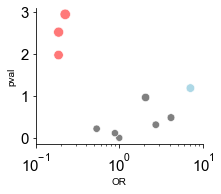

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
label_size = 15
plt.rcParams['font.family'] = 'arial'
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size

plt.subplots(figsize=[3,2.5])
ax = sns.scatterplot(single['x_y'], single['x_x'], s=50+20*single['x_x'], c=single['c'])
plt.xscale('log')
plt.xlim([0.1,10])

plt.ylabel('pval')
plt.xlabel('OR')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('../figures/clinical.pdf')

In [13]:
import seaborn as sns
from statannot import add_stat_annotation
from itertools import combinations

def swarmplot_anno(x=None, y=None, hue=None, data=None, order=None, hue_order=None,\
                   dodge=False, orient=None, color=None, palette=None, size=5,\
                   edgecolor='gray', linewidth=0, ax=None, cmp_x=True, **kwargs):
    
    ax = sns.swarmplot(x=x, y=y, hue=hue, data=data, order=order, hue_order=hue_order,\
                       dodge=dodge, orient=orient, color=color, palette=palette, size=size,\
                       edgecolor=edgecolor, linewidth=linewidth, ax=ax, **kwargs)
    ax = sns.boxplot(x=x, y=y, hue=hue, color='white')

    add_stat_annotation(ax, x=x, y=y, hue=hue,
                        box_pairs=(((i, k) for k in j) for j in combinations(hue.dropna().unique(),2) for i in x.dropna().unique()),
                        test='Mann-Whitney', text_format='simple', loc='inside', \
                        comparisons_correction=None , verbose=2)
    if cmp_x:
        add_stat_annotation(ax, x=x, y=y,
                            box_pairs=(i for i in combinations(x.dropna().unique(),2)),
                            test='Mann-Whitney', text_format='simple', loc='outside', \
                            comparisons_correction=None , verbose=2)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.get_legend().remove()

NegNeg_0 v.s. NegNeg_1: Mann-Whitney-Wilcoxon test two-sided, P_val=9.214e-03 U_stat=1.955e+02
PosNeg_0 v.s. PosNeg_1: Mann-Whitney-Wilcoxon test two-sided, P_val=6.426e-01 U_stat=1.330e+02
PosPos_0 v.s. PosPos_1: Mann-Whitney-Wilcoxon test two-sided, P_val=8.056e-01 U_stat=3.620e+02


([<matplotlib.axis.YTick at 0x7f7ff05c9e10>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8')])

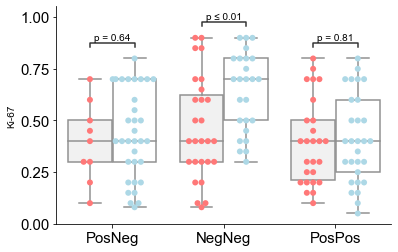

In [14]:
plt.rcParams['font.family'] = 'arial'
swarmplot_anno(df['HER2_Status']+df['ER_Status'],df['Ki-67'],df['pCR'],dodge=1, palette={0:'#ff7878',1:'lightblue'}, s=6, cmp_x=0)
plt.yticks([0,0.25,0.5,0.75,1])